# **Model Handcrafted**

### **Student Identification**

Student Name       | Student Email
-------------------|------------------
Daniel Branco      | r20191230@novaims.unl.pt
Filipe Dias        | r20181050@novaims.unl.pt
Gonçalo Lourenço   | r20191097@novaims.unl.pt
Inês Santos        | r20191184@novaims.unl.pt
Manuel Marreiros   | r20191223@novaims.unl.pt

### **Data Source**

Brain Tumor Classification (MRI) Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Drive with data: https://drive.google.com/file/d/1P3hcUss5Kqb28_WQUcTsuTW2VjNTX4pd/view?usp=share_link

### **Notebook Summary**





We will now perform iterative model construction, starting with a simple baseline model and adding (or removing, if that is the case) complexity as we go. For each model we will describe what layers are present on it and also possible improvements that will be taken into consideration when building the next model.

For computational reasons, at this stage we will train our models with only 10 epochs and a fixed learning rate of 0.001. After we determine which ones are performing better (which will be done by analysing the loss, accuracy and f1-score), this value may be increased to further boost performance.

Note: All our models were built using the functional API object-oriented approach. We chose this way to create the models over the Sequential approach because it allows for more complex network architectures, including multiple inputs and outputs, shared layers, and non-sequential connections between layers.

### **References**

1. [Convolutional Neural Networks with Dynamic Regularization
](https://arxiv.org/pdf/1909.11862.pdf)

### **Imports**

In [ ]:
pip install keras-tuner tensorflow-addons --quiet

In [ ]:
import os
import time
import math
import random 
import zipfile
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.initializers import GlorotNormal
import tensorflow_addons as tfa

import keras
from keras_tuner import Objective
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### **Things needed from previous notebooks**


In [ ]:
#EXPLORATION

# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Deep Learning/Projeto/"
main_folder, training_folder, testing_folder = "brain_tumor_data/", "Training/", "Testing/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'brain_tumor_data.zip', 'brain_tumor_data.zip')
    # Extract files
    zip_ = zipfile.ZipFile('brain_tumor_data.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

classes = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]

# Create empty lists to store the number of instances and class names
n_train = []
class_names = []

# Loop through each class in the dataset
for c in classes:
    # Get the number of instances in the training set for the current class
    n_train_c = len(os.listdir(path + main_folder + training_folder + f"/{c}"))
    # Append the number of instances and class name to their respective lists
    n_train.append(n_train_c)
    class_names.append(c)

image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='grayscale'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

n_classes = len(classes)
total_samples = np.sum(n_train)

#PREPROCESSING

class_weights = {}
for i in range(n_classes):
    w = total_samples / (2.0 * n_train[i])
    class_weights[i] = w

print('Class counts:', n_train)
print('Class weights:', class_weights)

input_shape = tuple(batch_x_train.shape)
rescaling = layers.Rescaling(1./255)
batchnormalization = layers.BatchNormalization()

rotation_layer = layers.RandomRotation(factor=0.05)
zoom_layer = layers.RandomZoom(height_factor=0.05, width_factor=0.05)
contrast_layer = layers.RandomContrast(factor=0.10)
brightness_layer = layers.RandomBrightness(factor=0.05)
noise_layer = layers.GaussianNoise(0.05)
flip_layer = layers.RandomFlip(mode='horizontal')
crop_layer = layers.RandomCrop(height=300, width=300)
translation_layer = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)

def augmentation(inputs):
    x = rotation_layer(inputs)
    x = zoom_layer(x)
    x = contrast_layer(x)
    x = brightness_layer(x)
    x = noise_layer(x)
    return x

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 4.779 seconds
Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Using 574 files for validation.
Class counts: [395, 826, 822, 827]
Class weights: {0: 3.632911392405063, 1: 1.7372881355932204, 2: 1.745742092457421, 3: 1.735187424425635}


###**CNN - V1**

In [ ]:
learning_rate = 0.001 
epochs = 10

We will start with a simple convolutional neural network, composed by 2 convolutional layers, each with a MaxPooling layer associated to it. We used the ReLU (Rectified Linear Unit) activation function since it is computationally efficient and helps to prevent the vanishing gradient problem (occurs when the gradients calculated during backpropagation become very small).

The first convolutional layer has 6 times the number of input channels, uses a 5x5 kernel size, and is initialized using GlorotNormal initialization. The second convolutional layer has 16 times the number of input channels, uses a 5x5 kernel size, and is also initialized using GlorotNormal initialization.

The output of the max pooling layer is then flattened into a 1-dimensional tensor, which is fed into a fully connected dense layer with 4 units and a softmax activation function.

In [ ]:
class CNN1(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=6*input_shape[-1], kernel_size=(5, 5), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(filters=16*input_shape[-1], kernel_size=(5, 5), kernel_initializer=initializers.GlorotNormal(seed=seed))      
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed)) 
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN1
cnn1 = CNN1(seed=seed)
# Builds the DAG 
cnn1.build(input_shape)
# Check the network
cnn1.summary()

Model: "cnn1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  156       
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  53828     
                                                              

In [ ]:
cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V1)
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 13s 64ms/step - loss: 30.5223 - accuracy: 0.4926 - F1-Score: 0.4743 - val_loss: 0.9177 - val_accuracy: 0.6481 - val_F1-Score: 0.6326
Epoch 2/10
36/36 [==============================] - 4s 86ms/step - loss: 1.7856 - accuracy: 0.6986 - F1-Score: 0.6908 - val_loss: 0.7595 - val_accuracy: 0.7143 - val_F1-Score: 0.7143
Epoch 3/10
36/36 [==============================] - 2s 52ms/step - loss: 1.1755 - accuracy: 0.7883 - F1-Score: 0.7819 - val_loss: 0.5363 - val_accuracy: 0.8136 - val_F1-Score: 0.8104
Epoch 4/10
36/36 [==============================] - 2s 59ms/step - loss: 0.6855 - accuracy: 0.8794 - F1-Score: 0.8810 - val_loss: 0.8813 - val_accuracy: 0.7265 - val_F1-Score: 0.7268
Epoch 5/10
36/36 [==============================] - 4s 87ms/step - loss: 0.4196 - accuracy: 0.9329 - F1-Score: 0.9334 - val_loss: 0.8180 - val_accuracy: 0.7735 - val_F1-Score: 0.7757
Epoch 6/10
36/36 [==============================] - 2s 50ms/step - loss: 0.3113 - a

Let's now create a function that allows us to plot the loss, accuracy and f1-scores of our models. This function will be called for every model we have and it will allow us to visually compare the performance of the different convolutional neural networks.

In [ ]:
def plot_learning_curves(history):

    # Create DataFrame object
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    # Create plot
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    # Plot loss curves
    axs[0].plot(df_hist["Epoch"], df_hist["loss"], color='darkred', label='Training Loss')
    axs[0].plot(df_hist["Epoch"], df_hist["val_loss"], color='indianred', label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Categorical cross-entropy')
    axs[0].set_title('Loss curves')
    axs[0].legend()
    axs[0].grid(True)

    # Plot accuracy curves
    axs[1].plot(df_hist["Epoch"], df_hist["accuracy"], color='darkblue', label='Training Accuracy')
    axs[1].plot(df_hist["Epoch"], df_hist["val_accuracy"], color='royalblue', label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Accuracy curves')
    axs[1].legend()
    axs[1].grid(True)

    # Plot F1-Score curves
    axs[2].plot(df_hist["Epoch"], df_hist["F1-Score"], color='green', label='Training F1-Score')
    axs[2].plot(df_hist["Epoch"], df_hist["val_F1-Score"], color='limegreen', label='Validation F1-Score')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('F1-Score')
    axs[2].set_title('F1 curves')
    axs[2].legend()
    axs[2].grid(True)

    plt.show()

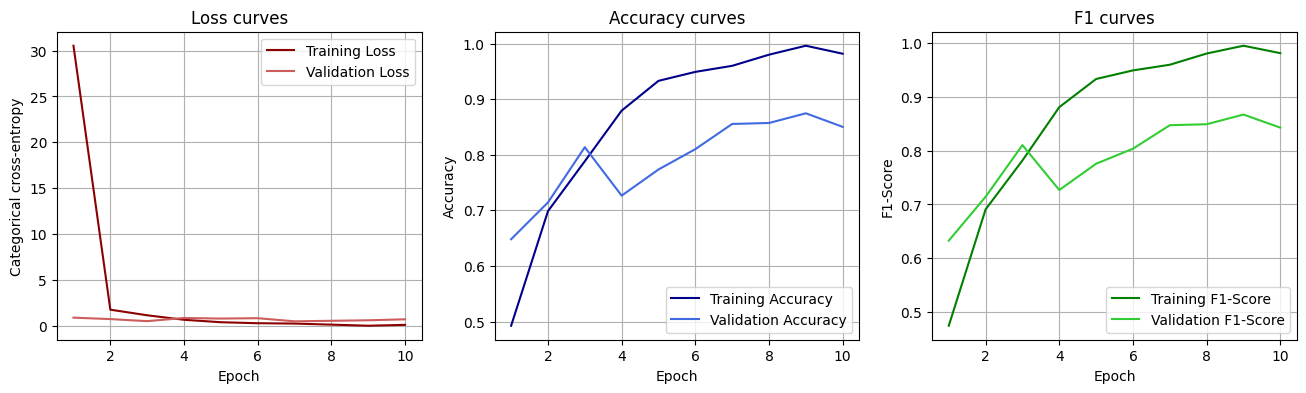

In [ ]:
plot_learning_curves(history1)

This CNN is producing good results, but, as epochs advance, we seem to be incurring in overfitting, since the accuracy and the f1-score on the validation dataset are smaller than the ones on the training dataset.

### **CNN - V2**

Let's try to improve the above model by introducing the rescaling layer and also include the augmentation images we generated. As we have said, augmentation is expected to make our model generalize better by artificially increasing the number of training examples.

In [ ]:
class CNN2(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.rescaling = layers.Rescaling(1./255)
        self.conv1 = layers.Conv2D(filters=6*input_shape[-1], kernel_size=(5, 5), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.maxpool1 = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(filters=16*input_shape[-1], kernel_size=(5, 5), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.maxpool2 = layers.MaxPooling2D(pool_size=(2, 2))      
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed)) 
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.rescaling(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN2
cnn2 = CNN2(seed=seed)
# Builds the DAG 
cnn2.build(input_shape)
# Check the network
cnn2.summary()

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  156       
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           multiple                  2416      
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                          

In [ ]:
cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V2)
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 5s 88ms/step - loss: 2.5052 - accuracy: 0.4765 - F1-Score: 0.3864 - val_loss: 1.0570 - val_accuracy: 0.5244 - val_F1-Score: 0.4686
Epoch 2/10
36/36 [==============================] - 3s 63ms/step - loss: 1.9962 - accuracy: 0.5814 - F1-Score: 0.5231 - val_loss: 0.7891 - val_accuracy: 0.6463 - val_F1-Score: 0.6247
Epoch 3/10
36/36 [==============================] - 2s 56ms/step - loss: 1.7683 - accuracy: 0.6376 - F1-Score: 0.6046 - val_loss: 0.8409 - val_accuracy: 0.6220 - val_F1-Score: 0.5812
Epoch 4/10
36/36 [==============================] - 2s 55ms/step - loss: 1.5752 - accuracy: 0.6712 - F1-Score: 0.6467 - val_loss: 0.7877 - val_accuracy: 0.6882 - val_F1-Score: 0.6595
Epoch 5/10
36/36 [==============================] - 3s 64ms/step - loss: 1.5486 - accuracy: 0.6834 - F1-Score: 0.6631 - val_loss: 1.0983 - val_accuracy: 0.5871 - val_F1-Score: 0.5098
Epoch 6/10
36/36 [==============================] - 2s 54ms/step - loss: 1.4311 - acc

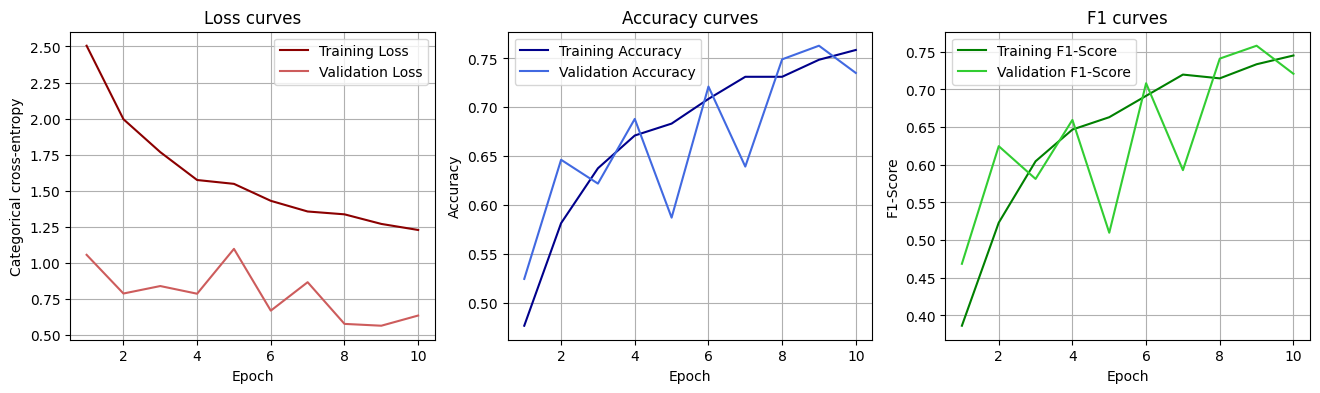

In [ ]:
plot_learning_curves(history2)

The overfitting was reduced, but at the cost of some model performance.

### **CNN - V3**

Let's now try a model with the same layers, although with more filters and a different kernel size. CNN2 has 6 and 16 filters in its first and second convolutional layers, respectively, while CNN3 has 32 and 64 filters in its first and second convolutional layers, respectively. This means that CNN3 has more parameters and can potentially learn more complex features than CNN2. Additionally, CNN3 uses smaller kernel sizes of 3x3 in both its convolutional layers, while CNN2 uses kernel sizes of 5x5.

We expect that by addding more filters we can increase the number of feature maps learned by the layer, which can enable the model to learn more complex and discriminating features. However, we also need to be aware that adding too many filters can lead to overfitting.

Changing the kernel size can also have an impact on the learned features. A larger kernel size can capture more global features, while a smaller kernel size can capture more local features. However, using a very large kernel size can lead to the loss of fine-grained detail in the input, when using a very small kernel size can lead to the loss of global information.

In [ ]:
class CNN3(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.rescaling = layers.Rescaling(1./255)
        self.conv1 = layers.Conv2D(filters=32*input_shape[-1], kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.maxpool1 = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(filters=64*input_shape[-1], kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.maxpool2 = layers.MaxPooling2D(pool_size=(2, 2))      
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed)) 
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.rescaling(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN3
cnn3 = CNN3(seed=seed)
# Builds the DAG 
cnn3.build(input_shape)
# Check the network
cnn3.summary()

Model: "cnn3_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     multiple                  0         
                                                                 
 conv2d_6 (Conv2D)           multiple                  320       
                                                                 
 activation_3 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                        

In [ ]:
cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V3)
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 6s 111ms/step - loss: 2.7450 - accuracy: 0.4604 - F1-Score: 0.3777 - val_loss: 1.1689 - val_accuracy: 0.5174 - val_F1-Score: 0.3590
Epoch 2/10
36/36 [==============================] - 3s 61ms/step - loss: 1.9181 - accuracy: 0.5893 - F1-Score: 0.5344 - val_loss: 0.8832 - val_accuracy: 0.6063 - val_F1-Score: 0.5131
Epoch 3/10
36/36 [==============================] - 2s 59ms/step - loss: 1.6940 - accuracy: 0.6490 - F1-Score: 0.6223 - val_loss: 0.8020 - val_accuracy: 0.6638 - val_F1-Score: 0.6237
Epoch 4/10
36/36 [==============================] - 2s 58ms/step - loss: 1.5298 - accuracy: 0.6868 - F1-Score: 0.6625 - val_loss: 0.6551 - val_accuracy: 0.7247 - val_F1-Score: 0.7103
Epoch 5/10
36/36 [==============================] - 5s 124ms/step - loss: 1.3586 - accuracy: 0.7156 - F1-Score: 0.6977 - val_loss: 1.1107 - val_accuracy: 0.6411 - val_F1-Score: 0.5908
Epoch 6/10
36/36 [==============================] - 3s 60ms/step - loss: 1.2879 - a

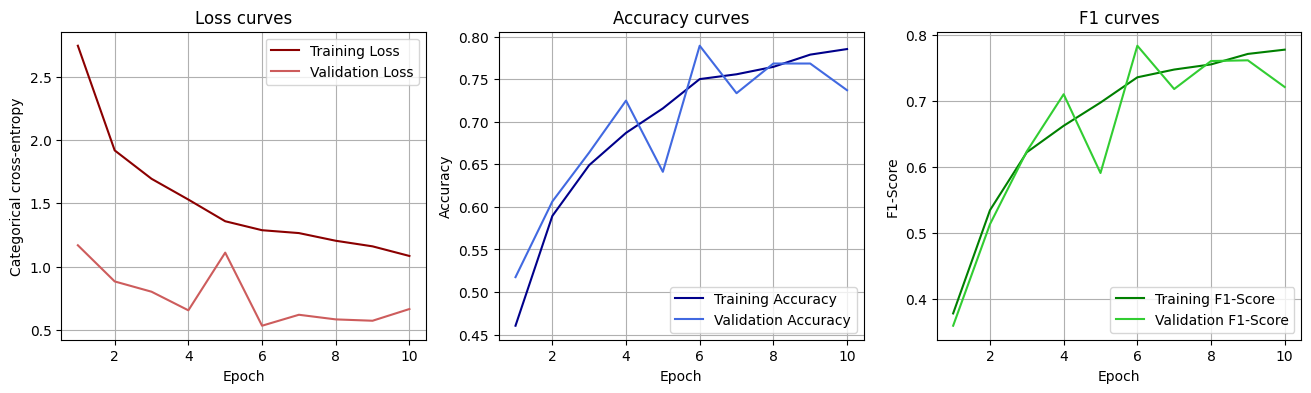

In [ ]:
plot_learning_curves(history3)

Analysing the graphs, we can see a small increase in performance.

### **CNN - V4**

Now we will be trying to do the image preprocessing with Batch Normalization instead of a simple Rescaling. The differences between these two preprocessing techniques were explained before, but our main motivation to do this change is mainly due to the fact that, in general, batch normalization is considered a more effective technique for normalizing inputs in deep neural networks than a simple rescale.

In [ ]:
class CNN4(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.batchnormalization = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=32*input_shape[-1], kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.maxpool1 = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(filters=64*input_shape[-1], kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.maxpool2 = layers.MaxPooling2D(pool_size=(2, 2))      
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed)) 
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.batchnormalization(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN1
cnn4 = CNN4(seed=seed)
# Builds the DAG 
cnn4.build(input_shape)
# Check the network
cnn4.summary()

Model: "cnn4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  multiple                 4         
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           multiple                  320       
                                                                 
 activation_4 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_7 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0      

In [ ]:
  cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V4)
history4 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 5s 70ms/step - loss: 3.4863 - accuracy: 0.4983 - F1-Score: 0.4546 - val_loss: 1.0298 - val_accuracy: 0.5470 - val_F1-Score: 0.5175
Epoch 2/10
36/36 [==============================] - 4s 95ms/step - loss: 1.8184 - accuracy: 0.6424 - F1-Score: 0.6162 - val_loss: 0.7998 - val_accuracy: 0.6864 - val_F1-Score: 0.6584
Epoch 3/10
36/36 [==============================] - 3s 62ms/step - loss: 1.5044 - accuracy: 0.7064 - F1-Score: 0.6903 - val_loss: 0.7799 - val_accuracy: 0.7352 - val_F1-Score: 0.7304
Epoch 4/10
36/36 [==============================] - 2s 60ms/step - loss: 1.3183 - accuracy: 0.7369 - F1-Score: 0.7273 - val_loss: 0.5808 - val_accuracy: 0.7718 - val_F1-Score: 0.7679
Epoch 5/10
36/36 [==============================] - 2s 59ms/step - loss: 1.1985 - accuracy: 0.7613 - F1-Score: 0.7532 - val_loss: 0.5045 - val_accuracy: 0.8014 - val_F1-Score: 0.8015
Epoch 6/10
36/36 [==============================] - 3s 87ms/step - loss: 1.0906 - acc

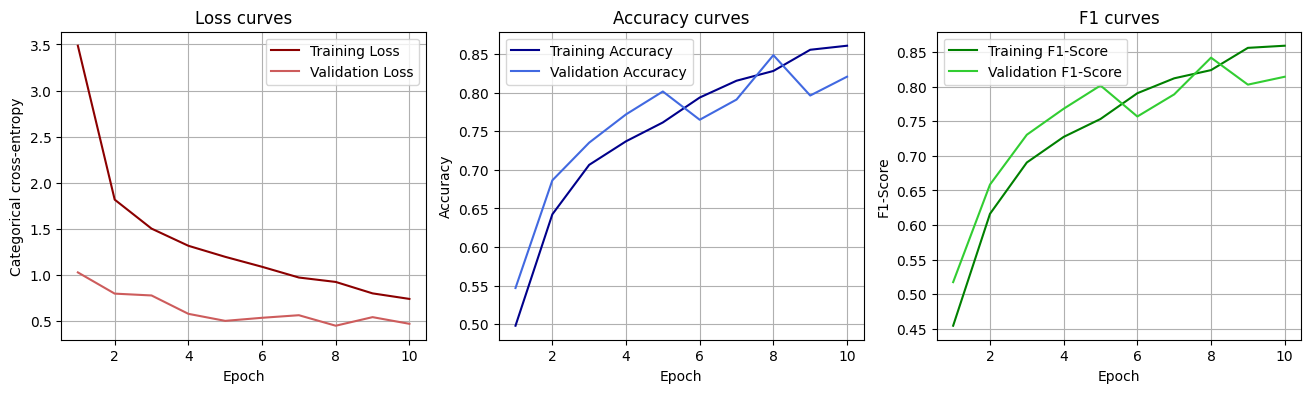

In [ ]:
plot_learning_curves(history4)

For this specific problem, Batch Normalization revealed itself to be, in fact, a better option.

### **CNN - V5**

However, we observe that some overfitting still persists in the model. We can try adding a dropout layer that randomly sets input units to 0 with a certain frequency/rate at each step during training time, which helps prevent overfitting from happening.

In [ ]:
class CNN5(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.batchnormalization = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=32*input_shape[-1], kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(filters=64*input_shape[-1], kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dropout = layers.Dropout(0.3) #rate at which input units are set to 0
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed)) 
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.batchnormalization(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN5
cnn5 = CNN5(seed=seed)
# Builds the DAG 
cnn5.build(input_shape)
# Check the network
cnn5.summary()

Model: "cnn5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  multiple                 4         
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          multiple                  320       
                                                                 
 activation_5 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_9 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          multiple                  18496     
                                                                 
 dropout (Dropout)           multiple                  0      

In [ ]:
cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V5)
history5 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 6s 86ms/step - loss: 3.0370 - accuracy: 0.4974 - F1-Score: 0.4571 - val_loss: 0.7812 - val_accuracy: 0.7038 - val_F1-Score: 0.6998
Epoch 2/10
36/36 [==============================] - 3s 68ms/step - loss: 1.8223 - accuracy: 0.6411 - F1-Score: 0.6186 - val_loss: 0.9183 - val_accuracy: 0.6359 - val_F1-Score: 0.6388
Epoch 3/10
36/36 [==============================] - 3s 70ms/step - loss: 1.5760 - accuracy: 0.6990 - F1-Score: 0.6869 - val_loss: 0.9864 - val_accuracy: 0.6307 - val_F1-Score: 0.5745
Epoch 4/10
36/36 [==============================] - 4s 107ms/step - loss: 1.4193 - accuracy: 0.7208 - F1-Score: 0.7059 - val_loss: 0.8079 - val_accuracy: 0.6829 - val_F1-Score: 0.6645
Epoch 5/10
36/36 [==============================] - 3s 68ms/step - loss: 1.1857 - accuracy: 0.7718 - F1-Score: 0.7650 - val_loss: 0.6167 - val_accuracy: 0.7352 - val_F1-Score: 0.7294
Epoch 6/10
36/36 [==============================] - 3s 66ms/step - loss: 1.0859 - ac

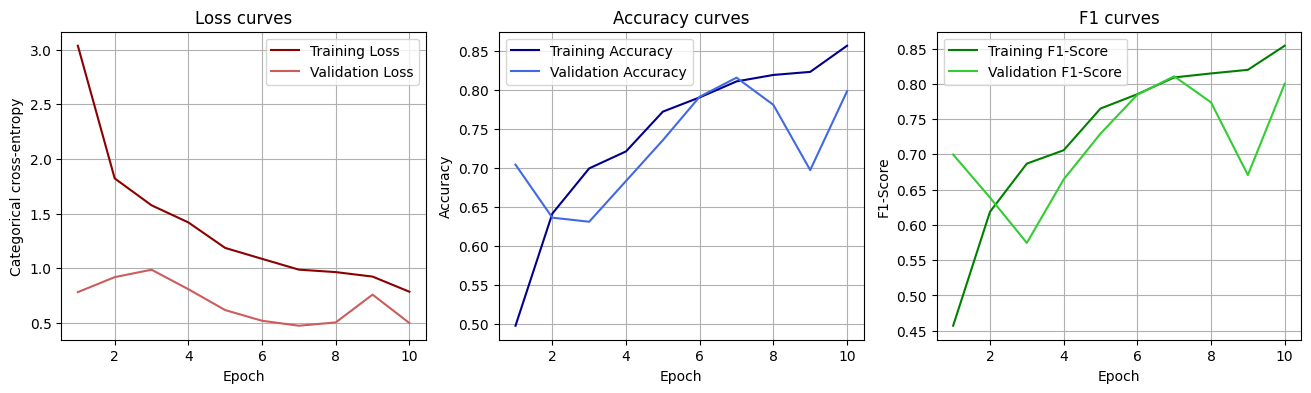

In [ ]:
plot_learning_curves(history5)

Note: We tried to add more dropout layers but we've noticed that the network was losing too much information, and efficiency was suffering. This is due to the fact that each dropout layer essentially removes a portion of the network's information, which can impair the network's capacity to recognize intricate patterns and make precise forecasts.

In some circumstances, regularizing the network and avoiding overfitting may only require the addition of a single dropout layer, which we believe to be our case.

### **CNN - V6**

Now let's try to apply some regularization techniques.

Since convolutional layers and the dense layer have the most learnable parameters in the model and regularization can help avoid overfitting, we added both kernel_regularizer and activity_regularizer to these layers.

Larger weights in the levels are penalized by the kernel_regularizer. The model is urged to learn smaller weights by including this regularization component in the loss function, which can aid in preventing overfitting.

Larger activations of the layer outputs are penalized by the activity_regularizer. Larger activations may be an indication that the model is overfitting to the training data, which can help avoid overfitting.

In [ ]:
class CNN6(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.batchnormalization = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(
            filters=32*input_shape[-1], 
            kernel_size=(3, 3), 
            kernel_initializer=initializers.GlorotNormal(seed=seed),
            kernel_regularizer=regularizers.l2(0.001), # Adding kernel_regularizer
        )
        self.relu = layers.Activation("relu")
        self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(
            filters=64*input_shape[-1], 
            kernel_size=(3, 3), 
            kernel_initializer=initializers.GlorotNormal(seed=seed),
            kernel_regularizer=regularizers.l2(0.001), # Adding kernel_regularizer
        )
        self.dropout = layers.Dropout(0.3) #rate at which input units are set to 0
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(
            units=4, 
            activation="softmax", 
            kernel_initializer=initializers.GlorotNormal(seed=seed),
            kernel_regularizer=regularizers.l2(0.001), # Adding kernel_regularizer
            activity_regularizer=regularizers.l1(0.001) # Adding activity_regularizer
        ) 
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.batchnormalization(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN6
cnn6 = CNN6(seed=seed)
# Builds the DAG 
cnn6.build(input_shape)
# Check the network
cnn6.summary()

Model: "cnn6_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  multiple                 4         
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          multiple                  320       
                                                                 
 activation_7 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_11 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          multiple                  18496     
                                                                 
 dropout_2 (Dropout)         multiple                  0    

In [ ]:
cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V6)
history6 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 5s 74ms/step - loss: 3.4198 - accuracy: 0.5105 - F1-Score: 0.4668 - val_loss: 1.4684 - val_accuracy: 0.4965 - val_F1-Score: 0.4694
Epoch 2/10
36/36 [==============================] - 4s 85ms/step - loss: 1.9170 - accuracy: 0.6307 - F1-Score: 0.6040 - val_loss: 0.7664 - val_accuracy: 0.7352 - val_F1-Score: 0.7308
Epoch 3/10
36/36 [==============================] - 3s 67ms/step - loss: 1.6308 - accuracy: 0.6807 - F1-Score: 0.6657 - val_loss: 0.7557 - val_accuracy: 0.7387 - val_F1-Score: 0.7328
Epoch 4/10
36/36 [==============================] - 3s 67ms/step - loss: 1.4124 - accuracy: 0.7400 - F1-Score: 0.7268 - val_loss: 0.8095 - val_accuracy: 0.7091 - val_F1-Score: 0.6860
Epoch 5/10
36/36 [==============================] - 4s 109ms/step - loss: 1.3314 - accuracy: 0.7618 - F1-Score: 0.7558 - val_loss: 0.8637 - val_accuracy: 0.7160 - val_F1-Score: 0.6997
Epoch 6/10
36/36 [==============================] - 3s 68ms/step - loss: 1.2633 - ac

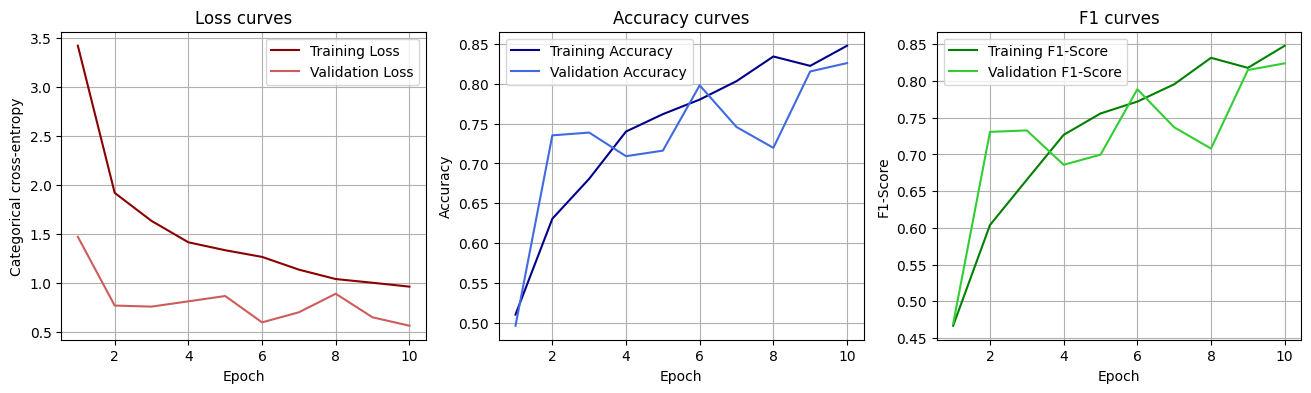

In [ ]:
plot_learning_curves(history6)

### **CNN - V7**

Let's now try to add attention mechanisms to this model. This way, it is explected that the model can better record information by focusing on key areas of the input picture with the aid of the attention mechanism. By paying attention to pertinent areas of the picture, it can also aid in reducing overfitting.

After the second convolutional layer in this model, we can add the attention method, enabling the model to pay attention to significant feature map areas before passing them through the dense layers. 

In [ ]:
class CNN7(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.batchnormalization = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(
            filters=32*input_shape[-1], 
            kernel_size=(3, 3), 
            kernel_initializer=initializers.GlorotNormal(seed=seed),
            kernel_regularizer=regularizers.l2(0.001), # Adding kernel_regularizer
        )
        self.relu = layers.Activation("relu")
        self.attention = layers.Attention() # Define Attention layer
        self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))          
        self.conv2 = layers.Conv2D(
            filters=64*input_shape[-1], 
            kernel_size=(3, 3), 
            kernel_initializer=initializers.GlorotNormal(seed=seed),
            kernel_regularizer=regularizers.l2(0.001), # Adding kernel_regularizer
        )
        self.dropout = layers.Dropout(0.3) #rate at which input units are set to 0
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(
            units=4, 
            activation="softmax", 
            kernel_initializer=initializers.GlorotNormal(seed=seed),
            kernel_regularizer=regularizers.l2(0.001), # Adding kernel_regularizer
            activity_regularizer=regularizers.l1(0.001) # Adding activity_regularizer
        ) 

    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.batchnormalization(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.attention([x, x]) # Apply Attention mechanism
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x
        
# Create an instance of CNN6
cnn7 = CNN7(seed=seed)
# Builds the DAG 
cnn7.build(input_shape)
# Check the network
cnn7.summary()


Model: "cnn7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  multiple                 4         
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          multiple                  320       
                                                                 
 activation_8 (Activation)   multiple                  0         
                                                                 
 attention (Attention)       multiple                  0         
                                                                 
 max_pooling2d_12 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          multiple                  18496  

In [ ]:
cnn7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V7)
history7 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 5s 78ms/step - loss: 3.7789 - accuracy: 0.3924 - F1-Score: 0.3415 - val_loss: 2.1176 - val_accuracy: 0.2230 - val_F1-Score: 0.1845
Epoch 2/10
36/36 [==============================] - 5s 131ms/step - loss: 2.3591 - accuracy: 0.4961 - F1-Score: 0.4642 - val_loss: 1.2290 - val_accuracy: 0.5540 - val_F1-Score: 0.5222
Epoch 3/10
36/36 [==============================] - 3s 74ms/step - loss: 2.2258 - accuracy: 0.5427 - F1-Score: 0.5093 - val_loss: 1.1231 - val_accuracy: 0.5366 - val_F1-Score: 0.4716
Epoch 4/10
36/36 [==============================] - 3s 73ms/step - loss: 2.0971 - accuracy: 0.5771 - F1-Score: 0.5440 - val_loss: 0.9446 - val_accuracy: 0.6481 - val_F1-Score: 0.6119
Epoch 5/10
36/36 [==============================] - 4s 112ms/step - loss: 1.9668 - accuracy: 0.5989 - F1-Score: 0.5667 - val_loss: 0.8291 - val_accuracy: 0.6672 - val_F1-Score: 0.6468
Epoch 6/10
36/36 [==============================] - 3s 74ms/step - loss: 1.8694 - a

In [ ]:
plot_learning_curves(history7)

The attention layer did not work as intended. Let's disregard this change.

### **CNN - V8 (VGG)**

The class BlockVGG creates a block of convolutional layers with batch normalization and activation function ReLU, followed by a max pooling layer. The class takes in the following parameters:

1. conv_layers: an integer that specifies the number of convolutional layers in the block.

2. filters: an integer that specifies the number of filters for each convolutional layer.

3. conv1x1: a boolean that indicates whether to add an additional 1x1 convolutional layer at the end of the block. This layer is used to reduce the number of channels before the max pooling layer in some VGG architectures.

4. batch_norm: a boolean that indicates whether to add batch normalization layers after each convolutional layer.

5. seed: an integer that specifies the random seed for weight initialization.

The class creates a block and adds the convolutional layers, batch normalization layers (if batch_norm is True), and ReLU activation layers to the model object. After adding all the layers, the function adds a max pooling layer with a pool size of 2 and stride of 2 to the model object.

Finally, the it returns the block.

In [ ]:
class BlockVGG(tf.keras.layers.Layer):
    def __init__(self, conv_layers, filters, conv1x1=True, batch_norm=True, seed=0, **kwargs):
        super().__init__(**kwargs)
        self.conv_layers = conv_layers
        self.filters = filters
        self.conv1x1 = conv1x1
        self.batch_norm = batch_norm
        self.seed = seed
        self.conv_layers_list = []
        self.bn_layers_list = []
        for l in range(conv_layers + conv1x1):
            self.conv_layers_list.append(layers.Conv2D(filters, 
                                  kernel_size=1 if l==conv_layers else 3, 
                                  padding="same",
                                  kernel_initializer=initializers.GlorotNormal(seed=seed)))
            if batch_norm:
                self.bn_layers_list.append(layers.BatchNormalization())
        
        self.relu = layers.Activation("relu")
        self.pool = layers.MaxPool2D(pool_size=2, strides=2)

    def call(self, inputs):
        x = inputs
        for l in range(self.conv_layers + self.conv1x1):
            x = self.conv_layers_list[l](x)
            if self.batch_norm and l < self.conv_layers:
                x = self.bn_layers_list[l](x)
            x = self.relu(x)
        
        x = self.pool(x)
        return x

In [ ]:
class CNN8(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.batchnormalization = layers.BatchNormalization()
        self.input_layer = layers.Input(shape=input_shape)
        self.block1 = BlockVGG(conv_layers=2, filters=32,conv1x1=False, seed=seed)
        self.block2 = BlockVGG(conv_layers=2, filters=64, conv1x1=False, seed=seed)
        self.block3 = BlockVGG(conv_layers=2, filters=128, conv1x1=True, seed=seed)
        self.globalmaxpool = layers.GlobalMaxPooling2D()          
        self.dropout = layers.Dropout(0.3) #rate at which input units are set to 0
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed)) 
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.batchnormalization(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.globalmaxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

# Create an instance of CNN6
cnn8 = CNN8(seed=seed)
# Builds the DAG 
cnn8.build(input_shape)
# Check the network
cnn8.summary()

Model: "cnn8_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_43 (Bat  multiple                 4         
 chNormalization)                                                
                                                                 
 block_vgg_3 (BlockVGG)      multiple                  9824      
                                                                 
 block_vgg_4 (BlockVGG)      multiple                  55936     
                                                                 
 block_vgg_5 (BlockVGG)      multiple                  238976    
                                                                 
 global_max_pooling2d_3 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 dropout_7 (Dropout)         multiple                  0   

In [ ]:
cnn8.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V8)
history8 = cnn8.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 10s 143ms/step - loss: 3.5708 - accuracy: 0.4133 - F1-Score: 0.3978 - val_loss: 2.3467 - val_accuracy: 0.3084 - val_F1-Score: 0.1178
Epoch 2/10
36/36 [==============================] - 5s 124ms/step - loss: 2.4189 - accuracy: 0.5052 - F1-Score: 0.4941 - val_loss: 1.3317 - val_accuracy: 0.3780 - val_F1-Score: 0.2753
Epoch 3/10
36/36 [==============================] - 5s 132ms/step - loss: 2.1187 - accuracy: 0.5658 - F1-Score: 0.5501 - val_loss: 1.0415 - val_accuracy: 0.5819 - val_F1-Score: 0.5497
Epoch 4/10
36/36 [==============================] - 5s 131ms/step - loss: 1.9801 - accuracy: 0.6054 - F1-Score: 0.5993 - val_loss: 1.5633 - val_accuracy: 0.4495 - val_F1-Score: 0.3787
Epoch 5/10
36/36 [==============================] - 5s 126ms/step - loss: 1.8179 - accuracy: 0.6468 - F1-Score: 0.6400 - val_loss: 1.3268 - val_accuracy: 0.3885 - val_F1-Score: 0.2986
Epoch 6/10
36/36 [==============================] - 5s 137ms/step - loss: 1.594

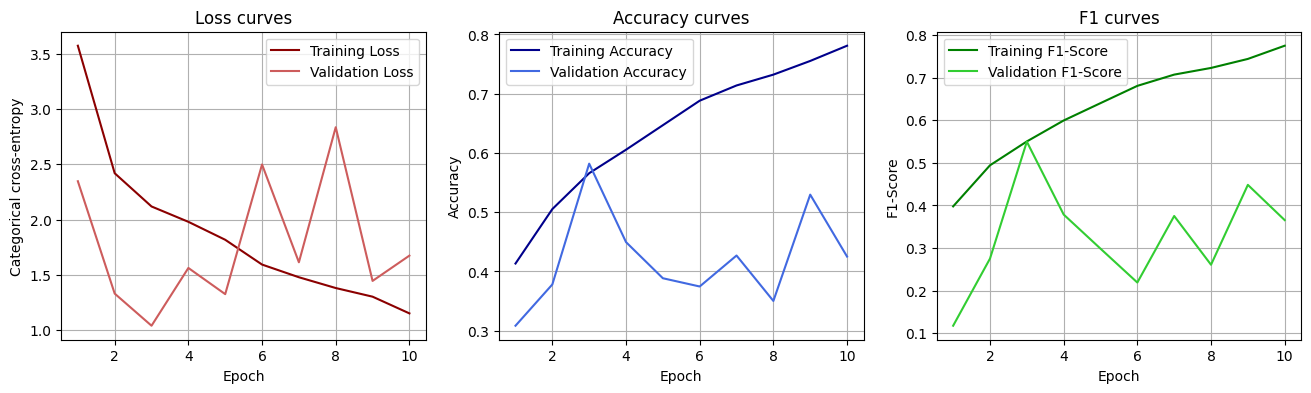

In [ ]:
plot_learning_curves(history8)

### **CNN - V9 (ResNet)**

ResNet is a kind of CNN called that allows for the training of even deeper neural networks without running into the issue of vanishing gradients. ResNet's central concept is the use of residual connections, which enable the addition of an earlier layer's input to a later layer's output, enabling the network to more quickly learn the underlying properties of the input. By lowering the dimensionality of the input, conducting feature extraction, and then projecting the result back to the original dimensions, the BottleneckBlock class is utilized to create these residual connections in CNN9.

In [ ]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x        

In [ ]:
class CNN9(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.augmentation = augmentation
        self.batchnormalization = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=4, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.dropout = layers.Dropout(0.3) #rate at which input units are set to 0
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.augmentation(inputs)
        x = self.batchnormalization(x)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dropout(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn9 = CNN9(seed=seed)
# Builds the DAG 
cnn9.build(input_shape)
# Check the network
cnn9.summary()

Model: "cnn9_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_59 (Bat  multiple                 4         
 chNormalization)                                                
                                                                 
 conv2d_58 (Conv2D)          multiple                  3200      
                                                                 
 batch_normalization_60 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_2 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 bottleneck_block_3 (Bottlen  multiple                 96384     
 eckBlock)                                                  

In [ ]:
cnn9.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
# Model training (V9)
history9 = cnn9.fit(ds_train, epochs=epochs, validation_data=ds_val, class_weight = class_weights)

Epoch 1/10
36/36 [==============================] - 9s 65ms/step - loss: 4.5472 - accuracy: 0.4469 - F1-Score: 0.4210 - val_loss: 1.8290 - val_accuracy: 0.1916 - val_F1-Score: 0.1277
Epoch 2/10
36/36 [==============================] - 2s 60ms/step - loss: 3.1123 - accuracy: 0.5662 - F1-Score: 0.5452 - val_loss: 1.9395 - val_accuracy: 0.2334 - val_F1-Score: 0.1962
Epoch 3/10
36/36 [==============================] - 4s 93ms/step - loss: 2.4573 - accuracy: 0.6015 - F1-Score: 0.5830 - val_loss: 1.5068 - val_accuracy: 0.4443 - val_F1-Score: 0.3675
Epoch 4/10
36/36 [==============================] - 3s 61ms/step - loss: 2.1115 - accuracy: 0.6381 - F1-Score: 0.6236 - val_loss: 1.3446 - val_accuracy: 0.4512 - val_F1-Score: 0.3925
Epoch 5/10
36/36 [==============================] - 2s 59ms/step - loss: 1.9107 - accuracy: 0.6646 - F1-Score: 0.6504 - val_loss: 0.9902 - val_accuracy: 0.5976 - val_F1-Score: 0.5838
Epoch 6/10
36/36 [==============================] - 2s 57ms/step - loss: 1.6967 - acc

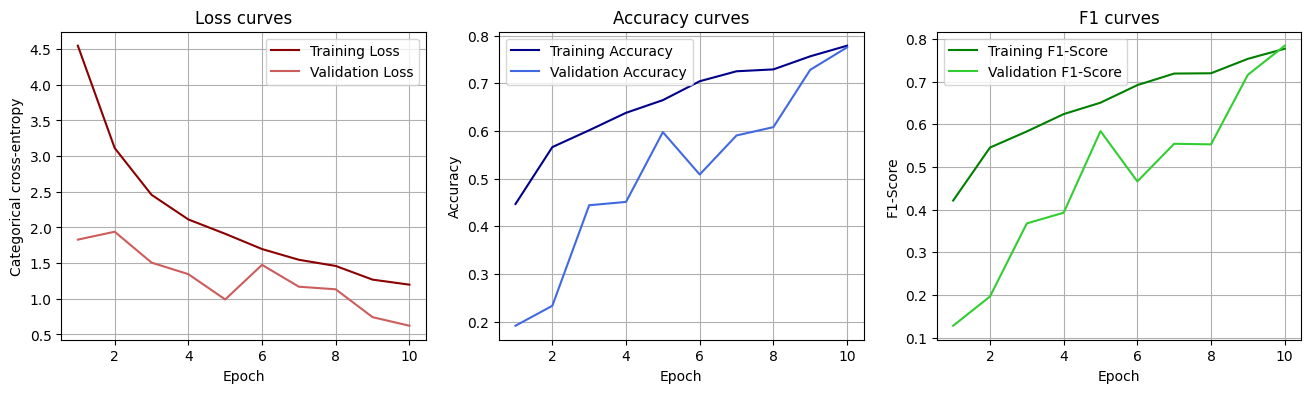

In [ ]:
plot_learning_curves(history9)